# **Examen**

In [129]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols


La base de datos con la que contamos brinda información sobre videojuegos que se han vendido alrededor del mundo. Esta cuenta con 16 variables que incluyen información principal como nombre, plataforma, año que se sacó al mercado, ventas en diferentes partes del mundo, rating, entre otras. Esta puede verse en la siguiente tabla.

In [130]:
#Archivo
video = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")
video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


Para aplicar modelos estadísticos y encontrar información valiosa, primero debemos hacer una limpieza de nulos de las variables que necesitamos.

## Parte 0. Limpieza de datos

Primero trabajaremos los nulos que utilizaremos en los modelos que propondremos más adelante.

In [131]:
video.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Se tratarán el número de críticos y el score de críticos con la media de cada variable.

In [132]:
video["Critic_Count"] = video["Critic_Count"].fillna(video["Critic_Count"].mean())
video["Critic_Score"] = video["Critic_Score"].fillna(video["Critic_Score"].mean())

In [133]:
video.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score          0
Critic_Count          0
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Además, la variabole rating igual tiene nulos, los cuales llenaremos con el string "S.Info" que signfiica "Sin información".

In [134]:
video["Rating"] = video["Rating"].fillna("S.Info.")

## Parte 1. Análisis de Regresión

Una vez que tenemos listas las variables que utilizaremos, generaremos análisis de regresión los cuales nos ayudarán a predecir las ventas globales depenidendo de distintas variables. Para ello, utiizaremos los modelos de Arboles de Regresión y Redes Neuronales ANN, las cuales evaluaremos para escoger la que nos brinde información más precisa.

Para ello, primero utilizaremos un mapa de calor para determinar cuáles son las variables mejor relacionadas a Global Sales, como podemos ver en el siguiente gráfico. 

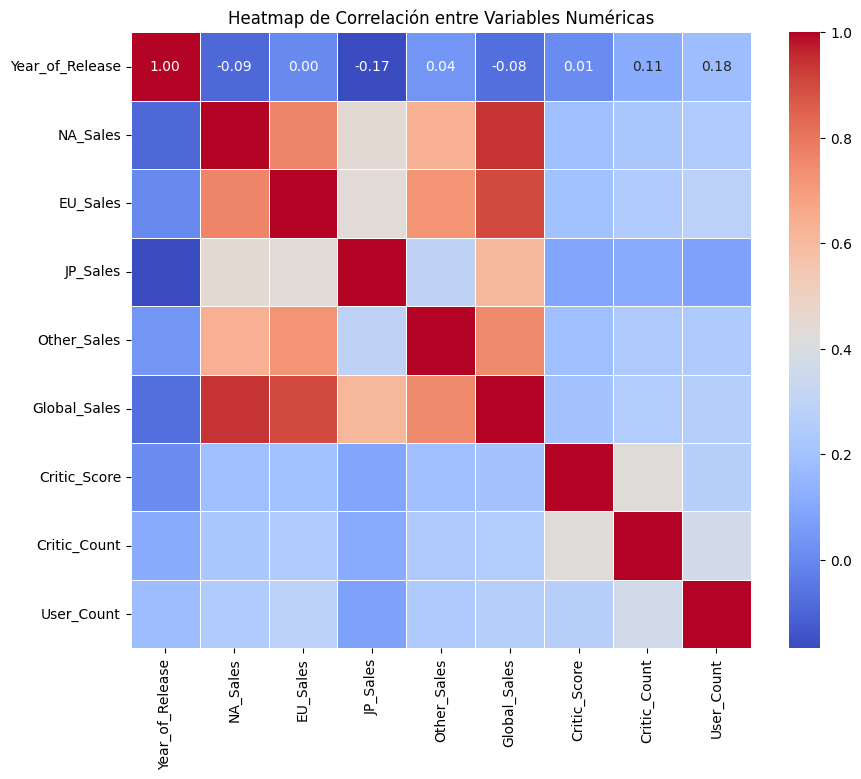

In [135]:
data_selected = video[["Year_of_Release", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales", "Critic_Score", "Critic_Count", "User_Count"]]
# 
# Calcula la matriz de correlación
correlation_matrix = data_selected.corr()
# 
# Crea el heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Heatmap de Correlación entre Variables Numéricas")
plt.show()

Observamso que las variables que tienen una relación más fuertes son todas las de ventas, lo cual era de suponerse debido a que la suma de estas son las ventas globales. Sin embargo, para tener otras variables que nos ayuden a predecir las ventas que se tendrán de nuevos videojuegos, aplicaremos variables como el número de Críticos y el Score que ellos dan a cada videojuego. 

Variables que usaremos:
* Ventas
* Critic Count
* Critic Score

En las siguientes líneas de código, definimos a X (nuestras variables dependientes, las cuales son las mencionadas anteriorimente) y Y, que es nuestra variable objetivo y que serán las ventas globales. Además dividiremos nuestra base de datos y separaremos el 30% de esta, de modo que el 70% restante nos ayude a entrenar el modelo (training_set) y el otro a evaluarlo (test_set).

In [136]:
y = video["Global_Sales"]
X = video[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score", "Critic_Count"]]

In [137]:
#Particionamos nuestra DB en training y test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

### Arboles de Regresión
Una vez que hemos preparado nuestra base de datos, generaremos nuestro modelo de Arboles de Regresión como se muestra en la ssiguientes líneas de código.

In [138]:
#El árbol de regresión.
model = DecisionTreeRegressor(random_state=44)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

Finalmente, hacemos la evaluación del modelo, tomando en cuenta métricas como:
* MAE: Error Absoluto Medio 
* MSE: Error Cuadrado Medio
* RMSE: Raíz del Error Cuadrático Medio
* R^2: R cuadrada la cual nos explica qué tanto de Y es explicado por el modelo. 

Los errores deben ser lo más bajos posibles y deben ser comparados con los errores de otros modelos que generemos, mientras que la R^2 debe ser lo más cercana a 1 posible.

In [139]:
# Calcula las métricas
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


MAE: 0.04445811785662363
MSE: 0.0705260544112448
RMSE: 0.2655674197096564
R^2: 0.9703886731716219


En este observamos errores bajos pero que deben ser comparados con otros modelos y una R^2 del 97%, por lo que el modelo explica el 97% de las ventas globales.

### Redes neuronales ANN

Posteriormente haremos redes neuronales con regresión para generar otro modelo que nos ayude a predecir las ventas globales, utlizando las mismas variables y división de training_set y test_set. En las siguientes líneas se entrena al modelo de redes neuronales. 

In [140]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [141]:
# Definir la arquitectura de la red neuronal para regresión
model = Sequential()
model.add(Dense(units=9, activation='relu', input_dim=6))
model.add(Dense(units=1, activation='linear'))

# Compilar el modelo para regresión
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo para regresión
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


330/330 [==============================] - 2s 3ms/step - loss: 1.0896 - val_loss: 1.0227
Epoch 2/10
330/330 [==============================] - 1s 3ms/step - loss: 0.1857 - val_loss: 0.1640
Epoch 3/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0777 - val_loss: 0.0962
Epoch 4/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0468 - val_loss: 0.0701
Epoch 5/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0308 - val_loss: 0.0502
Epoch 6/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0374
Epoch 7/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.0296
Epoch 8/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0232
Epoch 9/10
330/330 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0188
Epoch 10/10
330/330 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0157


La arquitectura de la red neuronal para regresión consiste en dos capas densas. La primera capa oculta tiene 9 unidades con la función de activación ReLU y una entrada de tamaño 6. La segunda capa de salida tiene 1 unidad con activación lineal. Se utiliza la función de pérdida de error cuadrático medio y el optimizador Adam. Durante el entrenamiento, se ejecutan 10 epochs con lotes de tamaño 32, y el 10% de los datos de entrenamiento se utiliza para la validación en cada época.

De igual manera podemos observar algunas predicciones así como el valor real para ver qué tanto se acerca al resultado deseado. 

In [142]:
# ...

# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_scaled, y_test)
print(f'Error Cuadrático Medio en el conjunto de prueba: {loss:.2f}')

# Convertir y_test a un array de NumPy
y_test_array = y_test.to_numpy()

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test_scaled)

# Visualizar algunas predicciones
for i in range(10):
    # Convertir las predicciones y los valores reales a tipos de datos compatibles con el formato de cadena
    predicciones_str = "{:.2f}".format(predictions[i][0])
    valor_real_str = "{:.2f}".format(y_test_array[i])

    print(f'Predicción: {predicciones_str}, Valor Real: {valor_real_str}')


157/157 [==============================] - 0s 2ms/step - loss: 0.0052
Error Cuadrático Medio en el conjunto de prueba: 0.01
157/157 [==============================] - 0s 2ms/step
Predicción: 0.16, Valor Real: 0.17
Predicción: 0.10, Valor Real: 0.05
Predicción: 0.04, Valor Real: 0.08
Predicción: -0.03, Valor Real: 0.02
Predicción: 0.18, Valor Real: 0.19
Predicción: 0.11, Valor Real: 0.12
Predicción: -0.03, Valor Real: 0.14
Predicción: 0.04, Valor Real: 0.06
Predicción: 0.05, Valor Real: 0.07
Predicción: 1.40, Valor Real: 1.42


Finalmente observamos las métricas del modelo.

In [143]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.03835182747980387
MSE: 0.005244698211398049
RMSE: 0.0724202886724297
R^2: 0.9977979418507048


En comparación con arboles de decisión, este presenta mejores resultados, pues los errores son menores que los de arboles de regresion y la R^2 es del 99%, lo que significa que el 99% de las ventas globales es explicado por nuestro modelo.

Sin embargo, debemos escoger la mejor opción. Se considera que debido a las buenas métricas de redes neuronales, este sería el mejor modelo, pues también es rapido y no utiliza tanta memoria como otros modelos que se han trabajado. Aun así, deberíamos hacer un análisis más profundo para verificar que no haya un overfitting en nuestro modelo.

## Parte 2. Comparación entre categorías

Por otro lado, haremos una comparacion entre categorías, principalmente las de rating comparando cómo se vende cada categoría en Norte América o si hay diferencias entre ellas. 
### ANOVA
Para ello utilizaremos un análisis ANOVA el cual nos dirá si hay diferencias significativas entre las medias de cada categoría.

Nuestras hipótesis son las siguientes:

*Hipótesis Nula: No existen diferencias significativas entre el Rating de la pelicula dependeindo de sus ventas globales*
\
*Hipótesis Alternativa: Existen diferencias significativas entre el Rating de la pelicula dependeindo de sus ventas globales*

In [144]:
OWA1 = video.iloc[ : , [5, 15]]

Generamos el modelo y obtenemos la siguiente respuesta:

In [145]:
#creamos una lista de las emosiones de CO2 y las agrupamos por cilindraje.
agrudatos1 = [group[1]['NA_Sales'] for group in OWA1.groupby('Rating')]

#Realizamos la prueba ANOVA 1 via.
estadistico_f, p_valor = stats.f_oneway(*agrudatos1)
#?

# Imprimimos el resultado
print("ANOVA de una vía - Resultados:")
print(f"Puntaje F: {estadistico_f:.2f}")
print(f"P-valor: {p_valor:.4f}")

# Para simplificar la interpretación de los resultados:
alpha = 0.05 #Podemos elegir un valor considerando nuestro nivel de confianza
if p_valor < alpha:
    print("Se rechaza la hipótesis nula. Existen diferencias significativas entre grupos.")
else:
    print("No se rechaza la hipótesis nula. No existen diferencias significativas entre grupos.")

ANOVA de una vía - Resultados:
Puntaje F: 25.44
P-valor: 0.0000
Se rechaza la hipótesis nula. Existen diferencias significativas entre grupos.


Ya que vemos que sí hay diferencias signficativas, procedemos a buscarlas en el siguiente gráfico.

c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


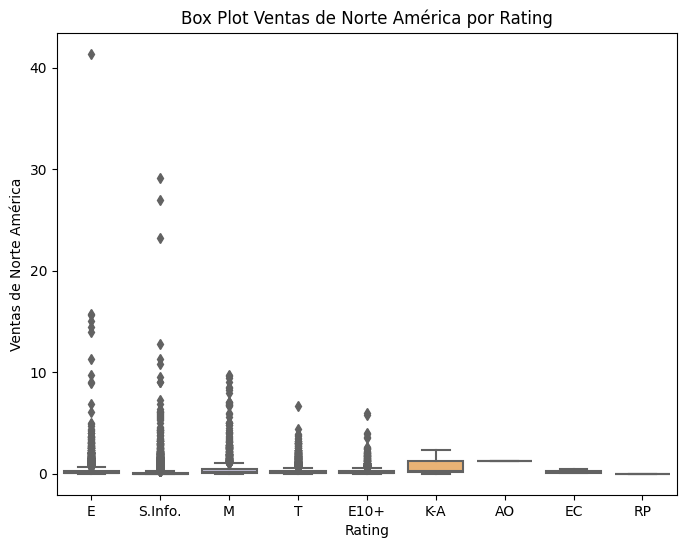

In [146]:
#visualizamos los datos:
# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Rating', y='NA_Sales', data=OWA1, palette='Set3')
plt.title('Box Plot Ventas de Norte América por Rating')
plt.xlabel('Rating')
plt.ylabel("Ventas de Norte América")
plt.show()

Aun así, es dificil observarlo en la imagen anterior, por lo que procedemos a hacer un análisis post hoc como el de Tukey para identificar dónde se encuentran dichas diferencias. 

In [147]:
#Prueba Post-Hoc
#para realizar comparaciones entre grupos
tukeyresultado1 = pairwise_tukeyhsd(OWA1['NA_Sales'], OWA1['Rating'])
print("\nResultados Tukey-Kramer prueba Post Hoc:")
print(tukeyresultado1)


Resultados Tukey-Kramer prueba Post Hoc:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
     AO       E   -0.936 0.9652 -3.4453  1.5734  False
     AO    E10+  -1.0112 0.9453 -3.5211  1.4987  False
     AO      EC  -1.0688 0.9462   -3.73  1.5925  False
     AO     K-A  -0.4067    1.0 -3.3038  2.4905  False
     AO       M  -0.7811 0.9889 -3.2909  1.7287  False
     AO      RP    -1.26 0.9163 -4.1571  1.6371  False
     AO S.Info.  -1.0764 0.9223 -3.5856  1.4327  False
     AO       T  -1.0034 0.9476 -3.5128   1.506  False
      E    E10+  -0.0752 0.0654 -0.1528  0.0023  False
      E      EC  -0.1328 0.9999 -1.0207  0.7552  False
      E     K-A   0.5293 0.9693 -0.9198  1.9784  False
      E       M   0.1548    0.0    0.08  0.2297   True
      E      RP   -0.324 0.9989 -1.7732  1.1251  False
      E S.Info.  -0.1405    0.0 -0.1906 -0.0904   True
      E       T  -0.067

Finalmente vemos que en categorías como E y M, E y T o las que no tienen información, son donde existen diferencias relevantes. 